In [1]:

import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix


import os
import warnings
warnings.filterwarnings('ignore')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
SIZE = 224

In [ ]:
data=os.listdir("/content/drive/MyDrive/new_dataset")
data

['validation', 'train']

In [ ]:
#Capture training data and labels into respective lists
train_images = []
train_labels = []

for directory_path in glob.glob("/content/drive/MyDrive/new_dataset/train/*"):
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

glaucoma
cataract


In [ ]:
train_images.shape

(1749, 224, 224, 3)

In [ ]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = []
for directory_path in glob.glob("/content/drive/MyDrive/new_dataset/validation/*"):
    fruit_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

#Convert lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)


In [ ]:
test_images.shape

(232, 224, 224, 3)

In [ ]:
np.unique(train_labels)

array(['cataract', 'glaucoma'], dtype='<U8')

In [ ]:
np.unique(test_labels)

array(['cataract', 'glaucoma'], dtype='<U8')

In [ ]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [ ]:
print(np.unique(train_labels_encoded))

[0 1]


In [ ]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [ ]:
 #Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:

#Load model without classifier/fully connected layers
from keras.applications.vgg16 import VGG16
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False

VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features

55/55 [==============================] - 10s 183ms/step


In [ ]:
X_for_training.shape

(1749, 25088)

In [ ]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

8/8 [==============================] - 1s 125ms/step


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(n_estimators=200,random_state=42)
model2.fit(X_for_training, y_train)

In [ ]:
#Now predict using the trained RF model.
prediction2 = model2.predict(X_test_features)
#Inverse le transform to get original label back.
prediction2 = le.inverse_transform(prediction2)

In [ ]:
#Print overall accuracy
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction2))

Accuracy =  0.9525862068965517


<Axes: >

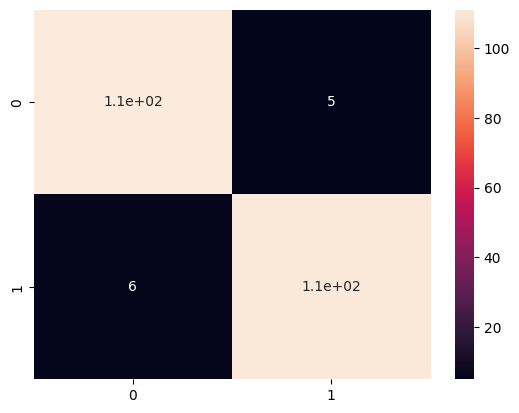

In [ ]:

#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(test_labels, prediction2)
#print(cm)
sns.heatmap(cm, annot=True)

1/1 [==============================] - 0s 19ms/step
The prediction for this image is:  ['cataract']
The actual label for this image is:  cataract


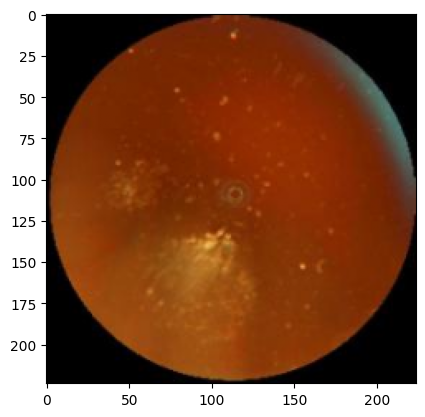

In [ ]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction2 = model2.predict(input_img_features)[0]
prediction2 = le.inverse_transform([prediction2])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction2)
print("The actual label for this image is: ", test_labels[n])

In [ ]:
model2.fit(X_for_training, y_train)
#Now predict using the trained RF model.
prediction1 = model1.predict(X_test_features)
#Inverse le transform to get original label back.
prediction1 = le.inverse_transform(prediction1)

In [ ]:
#Print overall accuracy
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction1))

Accuracy =  0.9698275862068966


<Axes: >

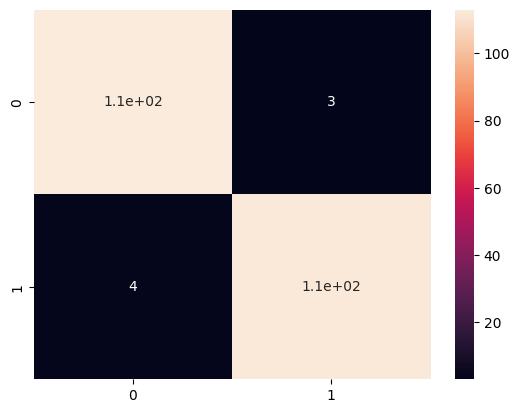

In [ ]:

#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(test_labels, prediction1)
#print(cm)
sns.heatmap(cm, annot=True)

In [ ]:

#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction1 = model1.predict(input_img_features)[0]
prediction1 = le.inverse_transform([prediction1])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction1)
print("The actual label for this image is: ", test_labels[n])
